# Compiler Optimization

## Setup

### Import Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.notebook import tqdm

### Variables

In [2]:
# Dataset
data_path = "/Users/cesar.salcedo/Documents/research/compiler_optimization/COBAYN/COBAYN/data"

# Hidden layer sizes for MLP
hs = [64, 64, 64]

# Learning Rate
lr = 0.001

# Epochs
num_epochs = 1

# Iterations
num_iterations = 1

## Dataset

In [3]:
# Load raw datasets
milepost = pd.read_csv(os.path.join(data_path, "ft_Milepost_cbench.csv"))
mica = pd.read_csv(os.path.join(data_path, "ft_MICA_cbench.csv"))
raw_runtimes = pd.read_csv(os.path.join(data_path, "cBench_onPandaboard_24app_5ds.csv"))

In [4]:
# Merge milepost and mica into single feature matrix
features = pd.merge(milepost, mica, how='inner', left_on=['APP_NAME','DATASET'], right_on=['APPLICATION_NAME','DATASET'])

In [5]:
# Transform runtimes to be in a mergable format
exe_labels = ["execution_time_" + str(i + 1) for i in range(5)]

frames = []
for i in range(5):
    ignored_labels = exe_labels[:]
    del ignored_labels[i]
    
    frame = raw_runtimes.drop(ignored_labels, axis=1)
    frame = frame.rename(columns={exe_labels[i] : "execution_time"})
    frame["DATASET"] = "dataset" + str(i + 1)
    frames.append(frame)
    
runtimes = pd.concat(frames, ignore_index=True)
runtimes = runtimes.drop(["code_size"], axis=1)

In [6]:
# Merge all together, one-hot encode dataset name, and replace strings by numbers
data = pd.merge(features, runtimes, how='inner', left_on=['APP_NAME','DATASET'], right_on=['APP_NAME','DATASET'])
data = pd.concat([pd.get_dummies(data["DATASET"]), data], axis=1)
data.drop(["APP_NAME", "APPLICATION_NAME", "DATASET"], axis=1, inplace=True)
data[data.columns[-8:-1]] = 1 * (data[data.columns[-8:-1]] != "X")
data

,dataset1,dataset2,dataset3,dataset4,dataset5,noBasicBlock,nobasicBlockSingleSocc,nobasicBlock2Socc,noBasicBlockSoccMore,noBasicBlockPred,...,mem_write_global_stride_512,mem_write_global_stride_4096,funsafe_math_optimizations,fno_guess_branch_probability,fno_ivopts,fno_tree_loop_optimize,fno_inline_functions,funroll_all_loops,o2,execution_time
0,1,0,0,0,0,129,37,31,0,61,...,15761599,15761792,0,0,0,0,0,0,0,2010.640
1,1,0,0,0,0,129,37,31,0,61,...,15761599,15761792,0,0,0,0,0,0,1,1777.070
2,1,0,0,0,0,129,37,31,0,61,...,15761599,15761792,0,0,0,0,0,1,0,2504.950
3,1,0,0,0,0,129,37,31,0,61,...,15761599,15761792,0,0,0,0,0,1,1,1715.030
4,1,0,0,0,0,129,37,31,0,61,...,15761599,15761792,0,0,0,0,1,0,0,1695.720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15355,0,0,0,0,1,3299,1486,1558,16,2205,...,4188468,4568914,1,1,1,1,0,1,1,246.399
15356,0,0,0,0,1,3299,1486,1558,16,2205,...,4188468,4568914,1,1,1,1,1,0,0,239.736
15357,0,0,0,0,1,3299,1486,1558,16,2205,...,4188468,4568914,1,1,1,1,1,0,1,190.470
15358,0,0,0,0,1,3299,1486,1558,16,2205,...,4188468,4568914,1,1,1,1,1,1,0,247.131


In [79]:
data_x = data.drop(["execution_time"], axis=1).to_numpy()
data_x = data_x[:, 60:]
data_y = data[["execution_time"]].to_numpy()

print("x shape: {}".format(data_x.shape))
print("y shape: {}".format(data_y.shape))

x shape: (15360, 50)
y shape: (15360, 1)


In [80]:
y_reshaped = data_y.reshape(128, -1)
data_y = (y_reshaped / y_reshaped[:, 1:2]).reshape(-1, 1)

In [81]:
test_programs = 5

idx = 5 * 128 * test_programs

test_x = data_x[:idx]
train_x = data_x[idx:]

test_y = data_y[:idx]
train_y = data_y[idx:]

In [82]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_x.fit(train_x)
train_x = scaler_x.transform(train_x)
test_x = scaler_x.transform(test_x)

# scaler_y = StandardScaler()
# scaler_y.fit(train_y)
# train_y = scaler_y.transform(train_y)

## Model

In [83]:
# Layer sizes
ls = [train_x.shape[1]] + hs

model_list = []

for i in range(len(ls) - 1):
    model_list.append(nn.Linear(ls[i], ls[i + 1]))
    model_list.append(nn.ReLU())

model_list.append(nn.Linear(ls[len(ls) - 1], 1))

model = nn.Sequential(*model_list)

print(model)

Sequential(
  (0): Linear(in_features=50, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=1, bias=True)
)


### Optimizer and Criterion

In [84]:
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=lr)

## Training loop

In [13]:
losses = []

for epoch in tqdm(range(num_epochs)):
    for i in tqdm(range(len(train_x))):
        x = torch.Tensor(train_x[i:i+1])
        y = torch.Tensor(train_y[i:i+1])
        
        y_hat = model(x)
        
        loss = criterion(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12160 [00:00<?, ?it/s]

## Plots

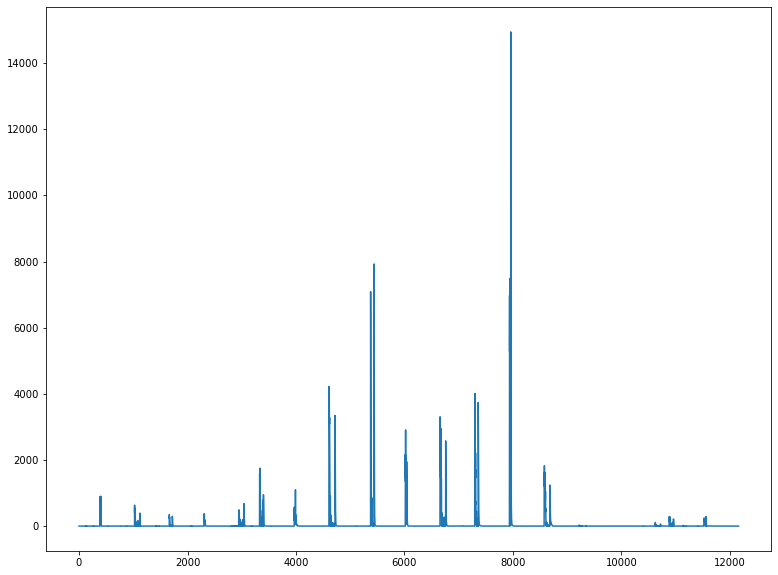

In [14]:
fig = plt.figure(figsize=(13,10))
plt.plot(losses)
plt.show()
plt.close(fig)

## Another approach

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [86]:
train_x.shape[1]

50

In [87]:
model = Sequential()
model.add(Dense(100, input_shape=(train_x.shape[1], ), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))

In [88]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
model.fit(train_x, train_y, epochs=100, batch_size=250, verbose=1, validation_split=0.2)

Epoch 1/100
39/39 [==============================] - 1s 5ms/step - loss: 165.5759 - mean_absolute_error: 4.8524 - val_loss: 13.2370 - val_mean_absolute_error: 2.2201
Epoch 2/100
39/39 [==============================] - 0s 2ms/step - loss: 116.7387 - mean_absolute_error: 4.7091 - val_loss: 10.9486 - val_mean_absolute_error: 1.8869
Epoch 3/100
39/39 [==============================] - 0s 2ms/step - loss: 86.7614 - mean_absolute_error: 4.0522 - val_loss: 12.7201 - val_mean_absolute_error: 1.8862
Epoch 4/100
39/39 [==============================] - 0s 2ms/step - loss: 65.7884 - mean_absolute_error: 3.2108 - val_loss: 13.9045 - val_mean_absolute_error: 1.8036
Epoch 5/100
39/39 [==============================] - 0s 2ms/step - loss: 51.3099 - mean_absolute_error: 2.7772 - val_loss: 27.6580 - val_mean_absolute_error: 2.2652
Epoch 6/100
39/39 [==============================] - 0s 2ms/step - loss: 43.1901 - mean_absolute_error: 2.5157 - val_loss: 34.9765 - val_mean_absolute_error: 2.4656
Epoch 7/

39/39 [==============================] - 0s 3ms/step - loss: 3.9876 - mean_absolute_error: 0.9670 - val_loss: 118.7455 - val_mean_absolute_error: 4.0224
Epoch 51/100
39/39 [==============================] - 0s 2ms/step - loss: 4.0705 - mean_absolute_error: 0.9812 - val_loss: 117.7596 - val_mean_absolute_error: 3.9873
Epoch 52/100
39/39 [==============================] - 0s 2ms/step - loss: 3.9710 - mean_absolute_error: 0.9606 - val_loss: 113.7015 - val_mean_absolute_error: 3.9282
Epoch 53/100
39/39 [==============================] - 0s 2ms/step - loss: 4.7981 - mean_absolute_error: 1.0249 - val_loss: 102.5700 - val_mean_absolute_error: 3.7421
Epoch 54/100
39/39 [==============================] - 0s 2ms/step - loss: 4.5291 - mean_absolute_error: 1.0081 - val_loss: 116.2491 - val_mean_absolute_error: 3.9696
Epoch 55/100
39/39 [==============================] - 0s 2ms/step - loss: 4.0235 - mean_absolute_error: 0.9620 - val_loss: 120.7424 - val_mean_absolute_error: 4.0431
Epoch 56/100
39/3

39/39 [==============================] - 0s 2ms/step - loss: 7.5318 - mean_absolute_error: 1.2795 - val_loss: 91.7809 - val_mean_absolute_error: 3.5346
Epoch 100/100
39/39 [==============================] - 0s 2ms/step - loss: 4.0064 - mean_absolute_error: 0.9885 - val_loss: 86.6144 - val_mean_absolute_error: 3.3985


In [89]:
train_results = model.evaluate(train_x, train_y, verbose=1)

380/380 [==============================] - 0s 1ms/step - loss: 20.3304 - mean_absolute_error: 1.4406


In [90]:
test_results = model.evaluate(test_x, test_y, verbose=1)

100/100 [==============================] - 0s 1ms/step - loss: 160.4891 - mean_absolute_error: 5.4813


In [91]:
prediction_y = model.predict(test_x)

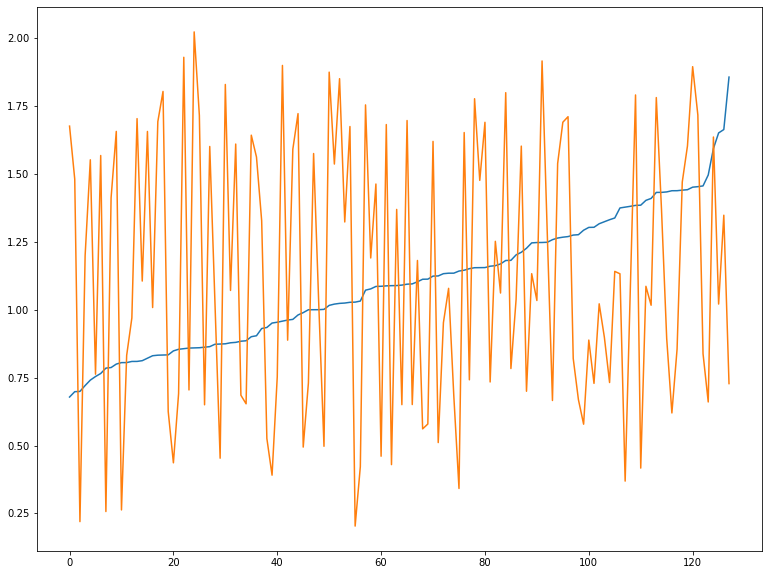

In [92]:
def plot_fig(curve1, curve2, prog, dataset):
    i = (128 * 5 * prog) + (128 * dataset)
    x1 = curve1[i: i + 128]
    x2 = curve2[i: i + 128]
    idx = np.argsort(x1[:, 0])
    fig = plt.figure(figsize=(13,10))
    plt.plot(x1[idx, 0])
    plt.plot(x2[idx, 0])
    plt.show()
    plt.close(fig)
    
plot_fig(test_y, prediction_y, 3, 0)